# Homework Assignment - DS

### Given:
You are given chunks of telemetry data of working equipment (9 sensors, 128 sec) that correspond to 6 different operating modes.
### The task:
1.	Analyze data, compute descriptive statistics, perform EDA. Assess data visually and make conclusions on operating models (classes) separability.
1.	Perform feature engineering, ideally create features that have clear meaning. Make some comments on created features, e.g. what they mean and how they can help you in the classification task.
1.	Predict operating modes of the equipment on the test data (X_test.npy), calculate precision, recall and ROC-AUC on y_test.npy. Develop 2-3 machine learning models, compare and discuss the results.
1.	If the score on any of the metric is lower than 0.92 on y_test.npy, then add some new features and aim to make the score above 0.92.

### Form of the delivery:
Please, deliver the solution in the form of a Jupyter notebook where EDA, comments and all the scores can be clearly seen.
### Timing:
Usually it takes 2 evenings, but can take up to 5 days.

---

### Solving
The task solving consists of 6 blocks:
1. Exploration data analysis (with graphs and statistical parameters);
2. Feature generation (relying on statistical parameters);
3. Models training (choosing of appropriate model);  
    3.0. Baseline (logreg);  
    3.1. XGBoost;  
    3.2. LightGBM;  
    3.3. Catboost;  
4. Feature importance analysis (choosing of usefull features);
5. Tunning of hyperparameters;
6. Neural Network models;  
    6.1 Simple dense model;  
    6.2. Convolutional model (1D and experiment with 2D);  

##### The best result was reached by LightGBM (ROC_AUC = 0.985).

In [1]:
import numpy as np
import pandas as pd

import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import optuna

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import skew, kurtosis
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

import warnings
warnings.filterwarnings("ignore")

In [2]:
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

### 1. EDA

In [3]:
# Data size
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7352, 128, 9), (7352, 6), (2947, 128, 9), (2947, 6))

In [4]:
# Fast check for NA
np.isnan(X_train).any(), np.isnan(y_train).any(), np.isnan(X_test).any(), np.isnan(y_test).any()

(False, False, False, False)

In [5]:
# Check target values and their amount
np.unique(y_train, return_counts=True)

(array([0., 1.]), array([36760,  7352]))

In [6]:
# Check if every measure has operating mode (at least one '1' in each measure)
np.unique(np.sum(y_train, axis=1))

array([1.])

Shot summary: The target is binary. The only one operating mode can be (and should be) active at the moment (there is no hybrid modes)

In [3]:
# Combine all data into one data frame and make label encoding of target (0-5) for convinient analysis
measures = X_train.shape[0]
sensors = X_train.shape[2]

data = pd.DataFrame(columns=np.append([f'X{sensor}' for sensor in range(sensors)], ['Mode']), dtype='object')

for measure in range(measures):
    for sensor in range(sensors):
        data.at[measure, f'X{sensor}'] = X_train[measure][:, sensor]
    data.at[measure, 'Mode'] = np.argmax(y_train[measure])
data.sample(5)

,X0,X1,X2,X3,X4,X5,X6,X7,X8,Mode
4867,"[1.3430739999999999, 0.9879028, 0.7060719, 0.5...","[-0.166521, -0.09188862, -0.1179973, -0.031030...","[-0.04234437, -0.06856382, -0.06662886, 0.0014...","[0.3535923, -0.0014526920000000002, -0.2832907...","[-0.09978196, -0.02527353, -0.05141549, 0.0356...","[0.1316412, 0.1055059, 0.1075562, 0.1757815, 0...","[0.4859554, 0.7366686, 0.8676195, 0.6591409, 0...","[-0.0414912, 0.2020761, 0.03372607, 0.01066396...","[0.2354133, 0.5013612, 0.694782, 0.6263759, 0....",2
80,"[1.0165520000000001, 0.8485091, 0.7518578, 0.7...","[-0.4693631, -0.5214301, -0.4736743, -0.324127...","[-0.1547907, -0.01946882, -0.04555395, -0.0681...","[0.01478672, -0.1532457, -0.249895, -0.265279,...","[-0.2385266, -0.2900742, -0.2417564, -0.091596...","[-0.1190291, 0.01587939, -0.01063868, -0.03369...","[0.2973856, 0.6444226, 0.8849052, 0.9118782, 0...","[-0.9486616, -0.9744048, -1.006967, -1.246464,...","[0.03721682, -0.3616981, -0.4051889, -0.285840...",0
6602,"[0.8414558, 0.8180806, 0.8598728, 0.8784479, 0...","[-0.3809101, -0.4106359, -0.3703121, -0.315417...","[-0.09904106, -0.06418929, -0.07774104, -0.092...","[-0.1369081, -0.1607704, -0.1194574, -0.101345...","[-0.1068382, -0.138111, -0.09927459, -0.045802...","[0.09445695, 0.1289475, 0.1149945, 0.09970631,...","[-0.5433194, -0.5541509, -0.5674264, -0.646708...","[0.1622027, 0.08766012, 0.08927167, 0.1376378,...","[0.3551773, 0.1969826, 0.06985043, 0.03377559,...",1
1908,"[1.0025819999999999, 0.9973389, 0.9941931, 0.9...","[-0.1560806, -0.1527683, -0.1510924, -0.150831...","[0.2126118, 0.2187176, 0.2262589, 0.2182791, 0...","[0.004299623, -0.0009625955000000001, -0.00412...","[-0.002977995, 0.00036663010000000004, 0.00207...","[-0.0022773339999999998, 0.003814002, 0.011340...","[0.03496171, 0.03491294, 0.03265654, 0.0303994...","[-0.00818589, -0.01208608, -0.009884322, -0.00...","[0.02000843, 0.01217841, 0.012691, 0.01531596,...",4
1747,"[1.02399, 1.0027059999999999, 0.9801576, 0.929...","[-0.4242288, -0.3556756, -0.2339827, -0.110424...","[-0.2934671, -0.2059887, -0.08974435, 0.017240...","[0.05067665, 0.02871338, 0.005358765, -0.04574...","[-0.1357104, -0.06789557, 0.05306259, 0.175891...","[-0.2866189, -0.1992732, -0.0830438, 0.0240423...","[-0.4169316, -0.8605723, -1.129682, -1.152185,...","[2.514384, 1.6737509999999998, 0.8937431, 0.51...","[0.408977, 0.07430421, 0.1223651, 0.5160795, 0...",1


Class: 0


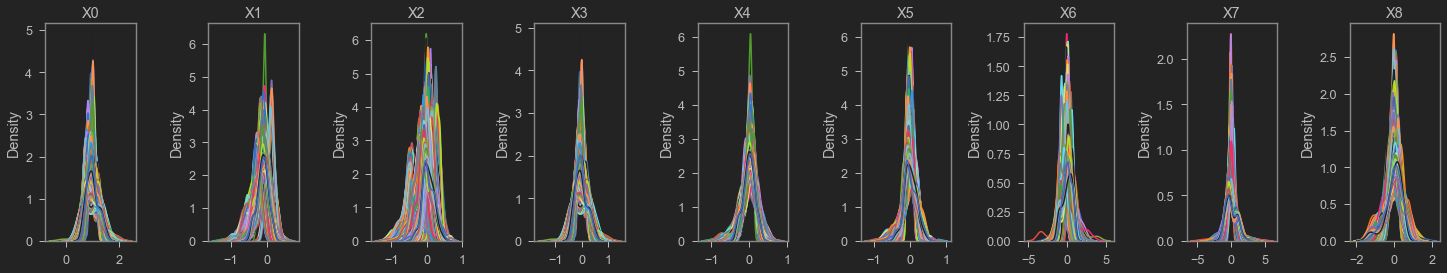

Class: 1


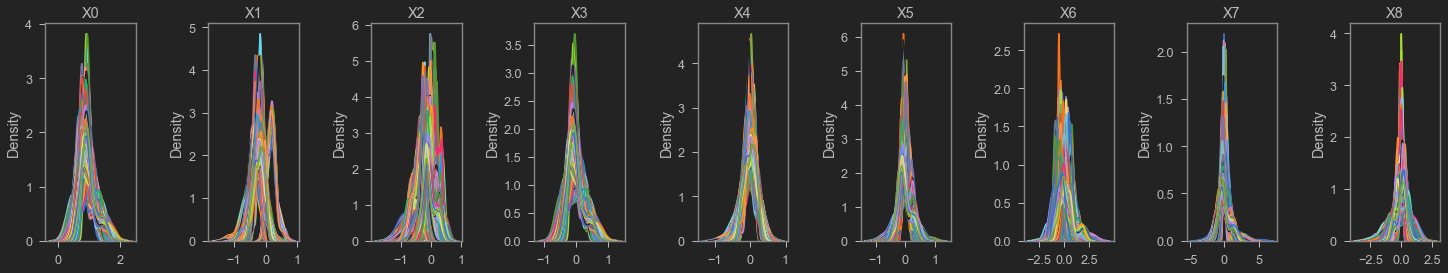

Class: 2


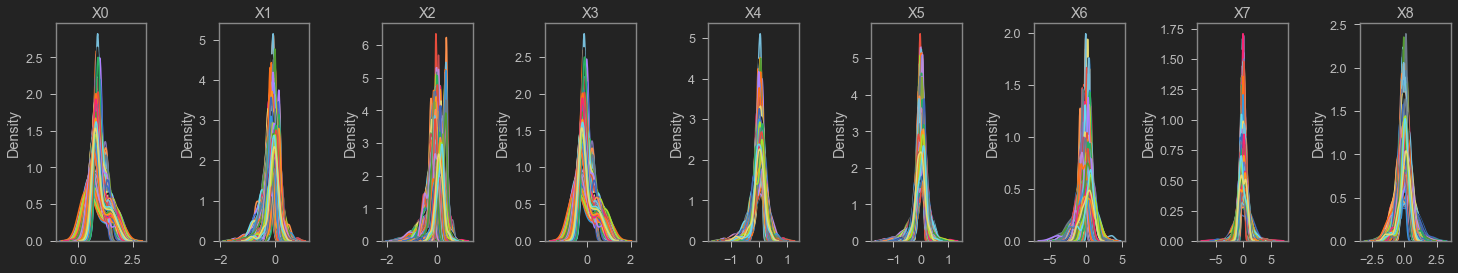

Class: 3


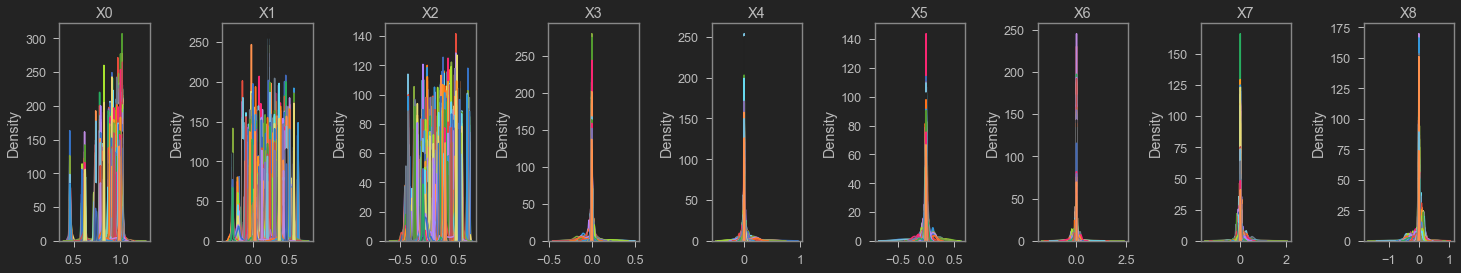

Class: 4


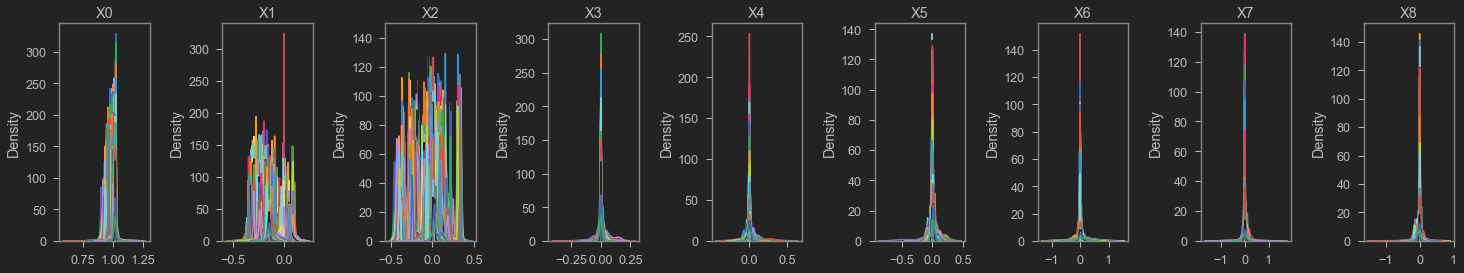

Class: 5


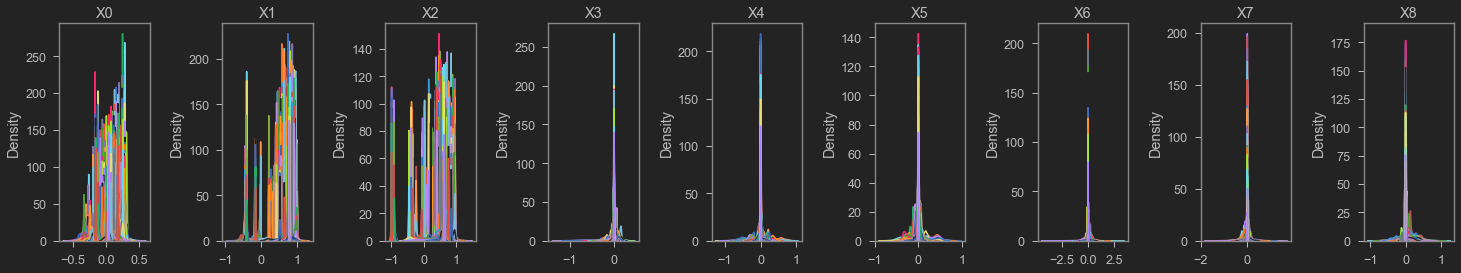

In [8]:
# "Quick look" sensor distribution graphs depending on target
for k in range(y_train.shape[1]):
    plt.figure(figsize=(25, 4))
    print(f'Class: {k}')
    selected = data.loc[data['Mode'] == k, :].drop(columns=['Mode']).reset_index(drop=True)
    for i in range(selected.shape[0]):
        for j in range(sensors):
            plt.subplot(int(f'1{sensors}{j+1}'))
            plt.title(f'X{j}')
            sns.kdeplot(selected.loc[i, f'X{j}'])
            plt.subplots_adjust(wspace=0.8)
    plt.show()

Sensors distribution for different operating modes has obvious differentiation between groups 0-2 and 3-5. Inside these groups the difference is less but can be detected relying on separate sensors.  
Let's compare them in detail on graphs with grouped measures with target differentiation.

In [4]:
merged_sensors_data = pd.DataFrame(columns=data.columns)

for k in range(y_train.shape[1]):
    selected = data.loc[data['Mode'] == k, :].drop(columns=['Mode'])
    _merged_sensors_data = pd.DataFrame()
    for i in range(sensors):
        _merged_sensors_data[f'X{i}'] = [item for sublist in selected.loc[:, f'X{i}'].values for item in sublist]
    _merged_sensors_data['Mode'] = k
    merged_sensors_data = pd.concat([merged_sensors_data, _merged_sensors_data], axis=0, ignore_index=True)

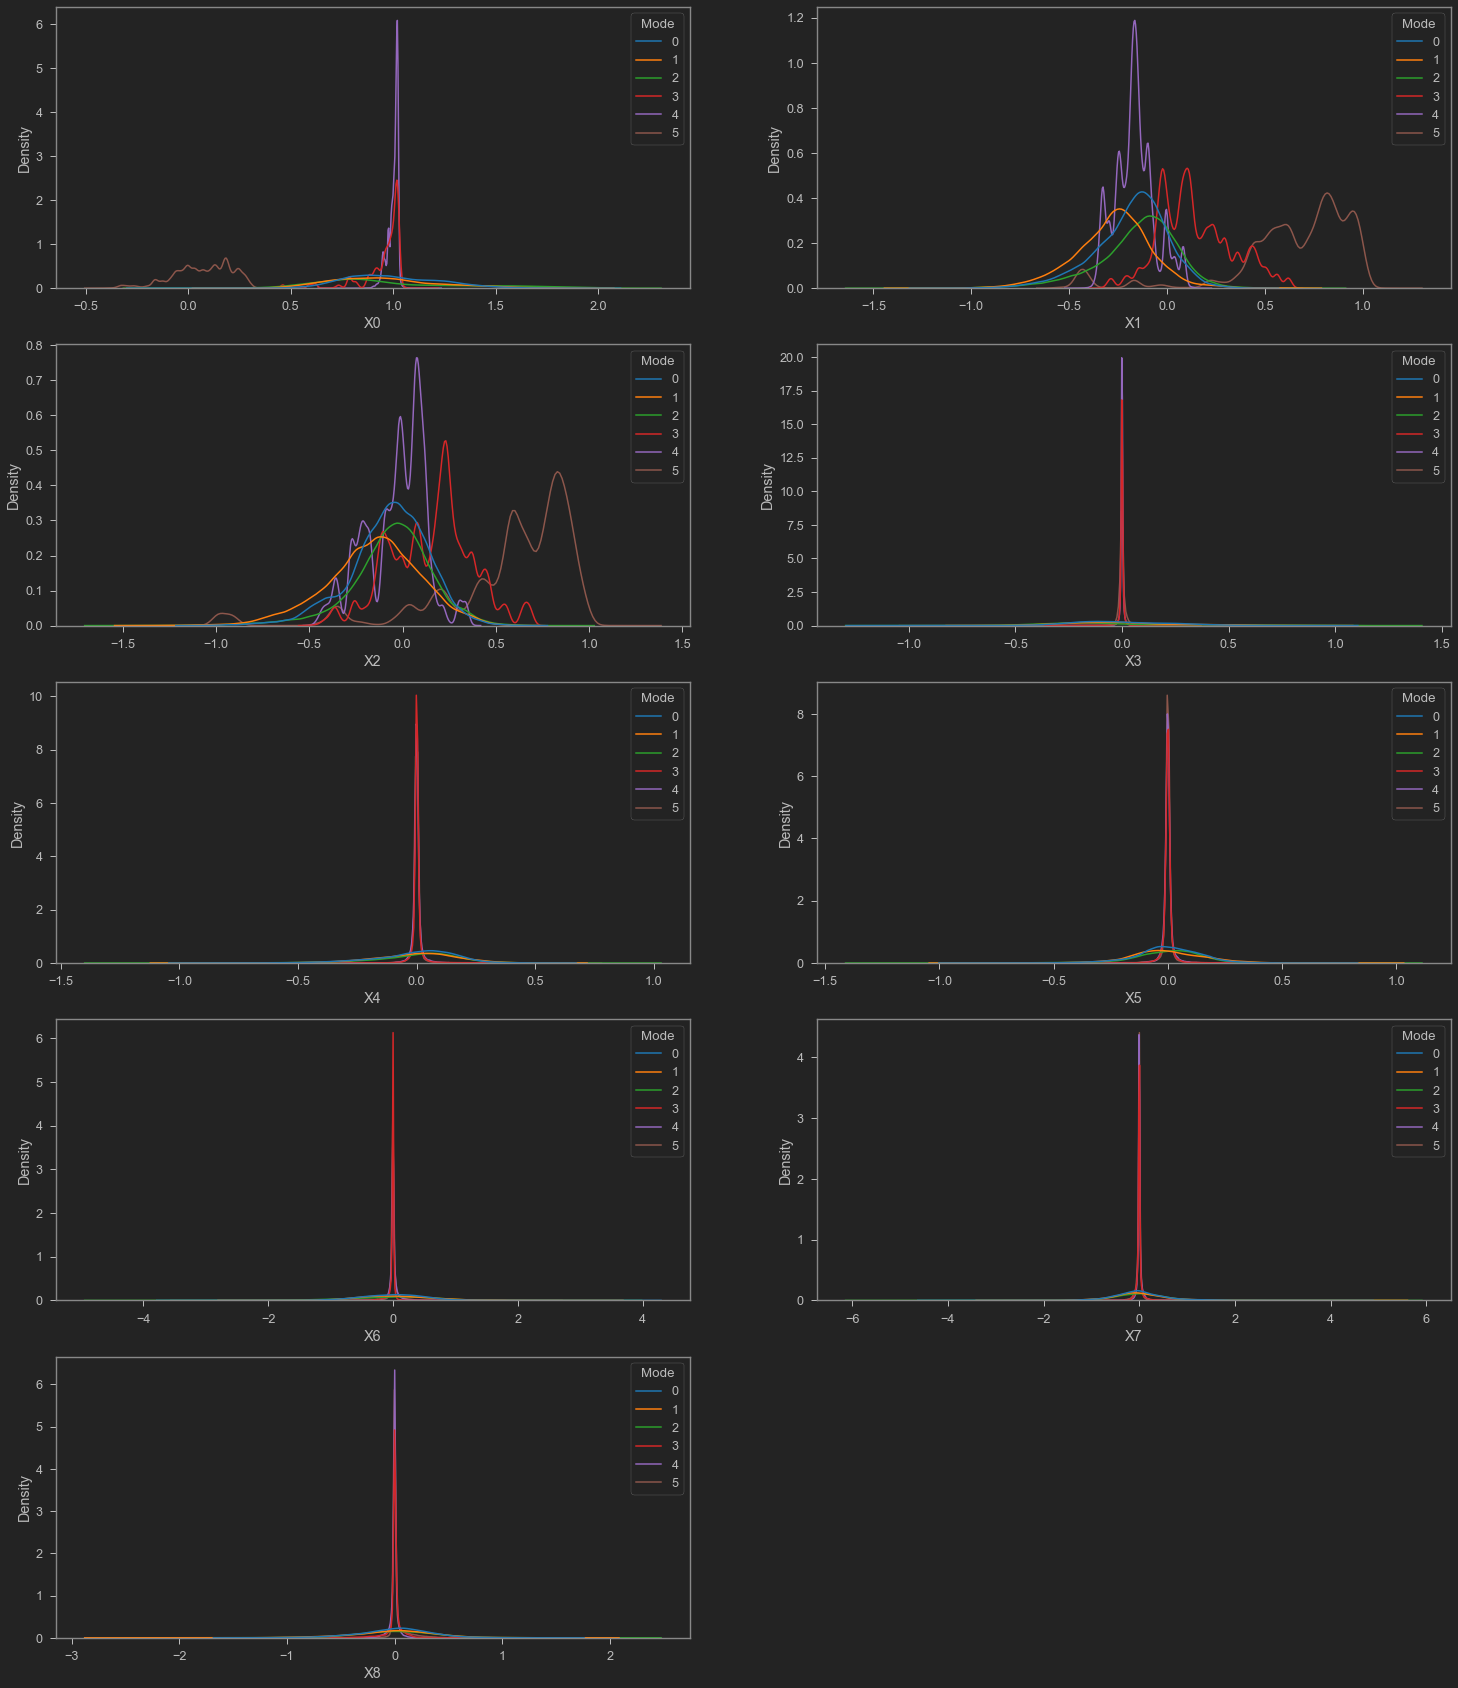

In [10]:
plt.figure(figsize=(25, 30))
for j in range(sensors):
    plt.subplot(int(f'{int(np.ceil(sensors/2))}2{j+1}'))
    sns.kdeplot(merged_sensors_data[f'X{j}'], hue=merged_sensors_data['Mode'], palette='tab10')
plt.show()

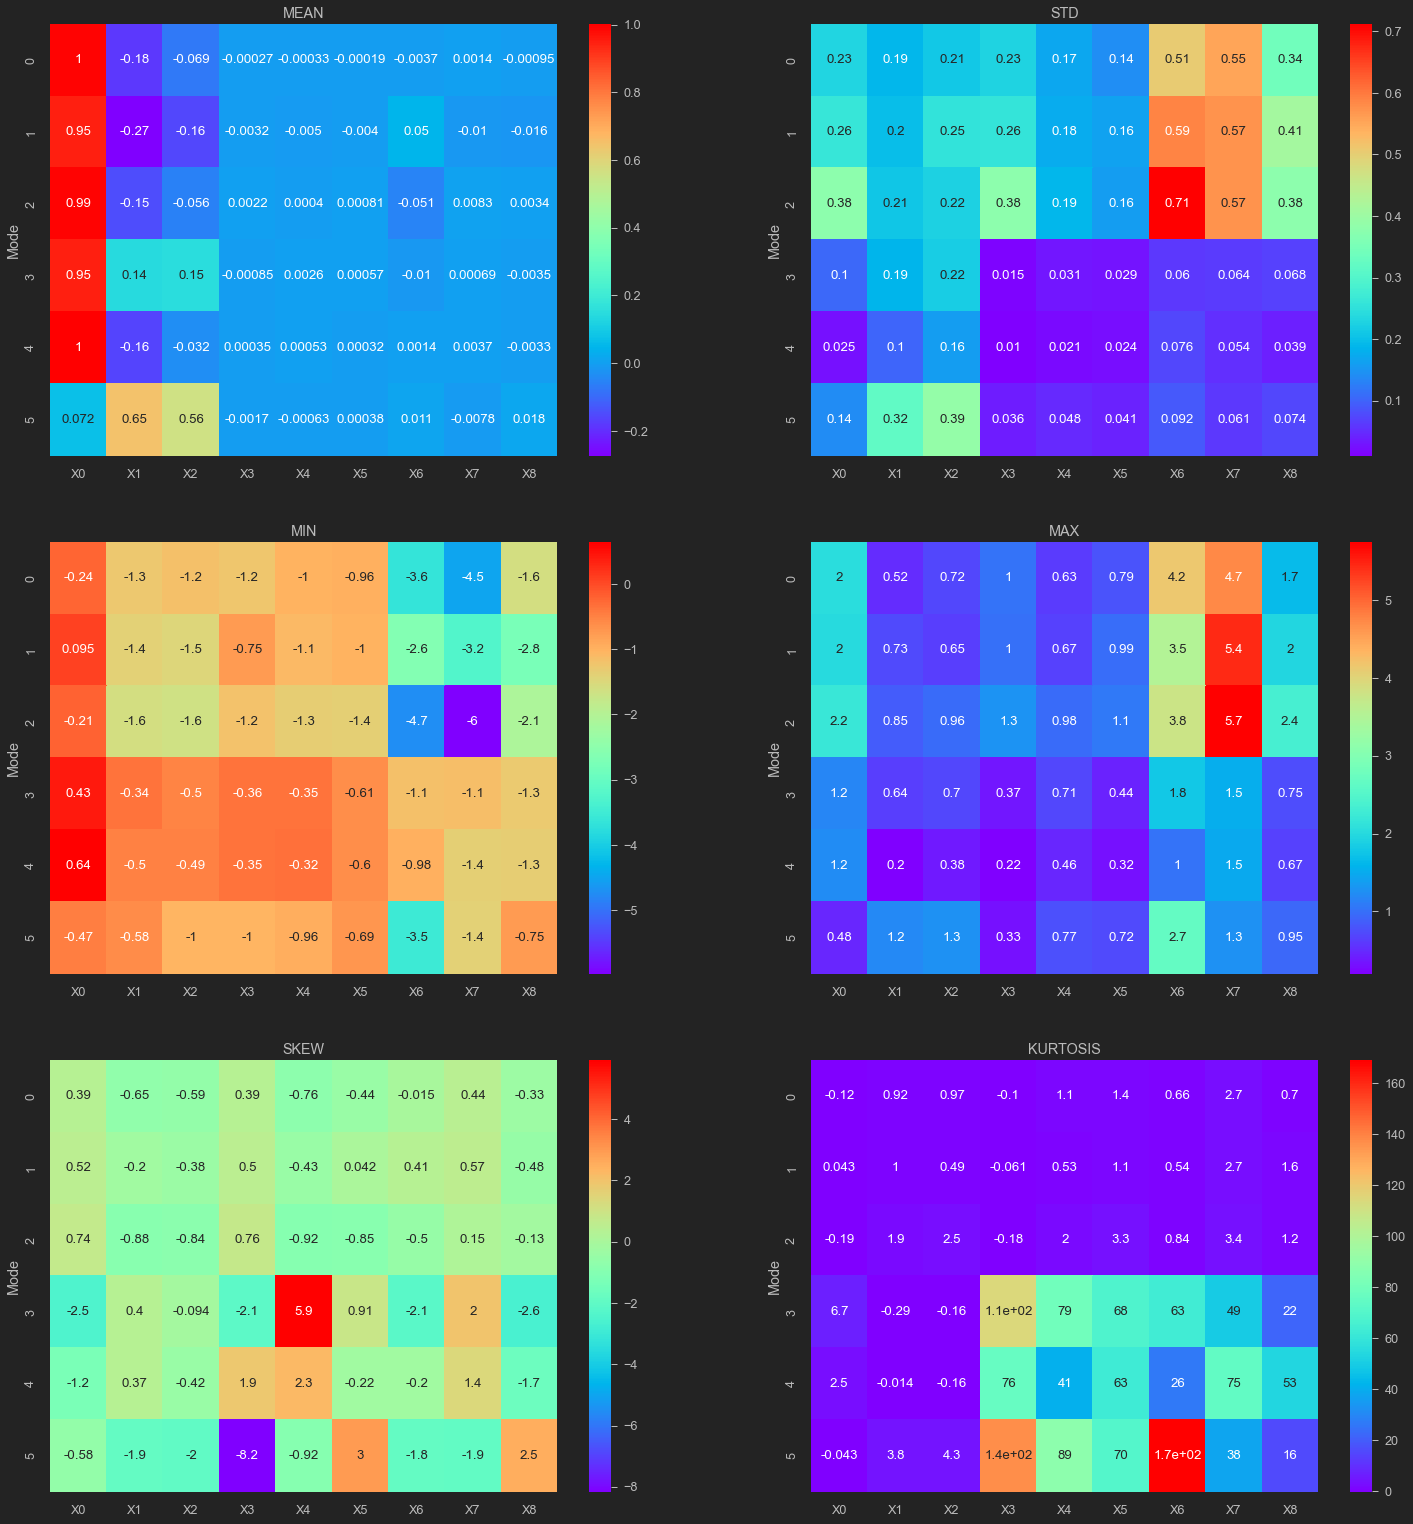

In [18]:
# Main statistics of combined data separated on sensors and target
plt.figure(figsize=(25, 27))
sns.set(font_scale=0.9)
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

plt.subplot(321)
plt.title('MEAN')
sns.heatmap(merged_sensors_data.groupby('Mode').agg(np.mean), annot=True, fmt='.2g', cmap='rainbow')

plt.subplot(322)
plt.title('STD')
sns.heatmap(merged_sensors_data.groupby('Mode').agg(np.std), annot=True, fmt='.2g', cmap='rainbow')

plt.subplot(323)
plt.title('MIN')
sns.heatmap(merged_sensors_data.groupby('Mode').agg(np.min), annot=True, fmt='.2g', cmap='rainbow')

plt.subplot(324)
plt.title('MAX')
sns.heatmap(merged_sensors_data.groupby('Mode').agg(np.max), annot=True, fmt='.2g', cmap='rainbow')

plt.subplot(325)
plt.title('SKEW')
sns.heatmap(merged_sensors_data.groupby('Mode').agg(skew), annot=True, fmt='.2g', cmap='rainbow')

plt.subplot(326)
plt.title('KURTOSIS')
sns.heatmap(merged_sensors_data.groupby('Mode').agg(kurtosis), annot=True, fmt='.2g', cmap='rainbow')

plt.show()

The first 3 sensors reflect a good class differentiation and probably has a high importance for classification. Two different groups can be seen on heatmaps as well as on histogramms above: 0-2 and 3-5. The differentian inside these group assumed more complex, except class 5 that can be easily selected by mean value and partially by 3-d and 4-th distribution moments (skew, kurtosis).

### 2. Features generation

In [5]:
def make_statistical_features(x: np.ndarray, y: np.ndarray) -> pd.DataFrame:
    """
    Method creates dataframe with main statistical features and label-encoded target
    
    :param x: input X data
    :param y: input Y data
    
    :return:  DataFrame with statistical features (mean, std, min, max, skew, kurtosis) and label-encoded target
    """
    measures = x.shape[0]
    sensors = x.shape[2]

    data = pd.DataFrame()

    for measure in range(measures):
        for sensor in range(sensors):
            data.at[measure, f'X{sensor}_mean'] = x[measure][:, sensor].mean()
            data.at[measure, f'X{sensor}_std'] = x[measure][:, sensor].std()
            data.at[measure, f'X{sensor}_min'] = x[measure][:, sensor].min()
            data.at[measure, f'X{sensor}_max'] = x[measure][:, sensor].max()
            data.at[measure, f'X{sensor}_skew'] = skew(x[measure][:, sensor])
            data.at[measure, f'X{sensor}_kurtosis'] = kurtosis(x[measure][:, sensor])
        data.at[measure, 'Mode'] = np.argmax(y[measure])
        
    return data

In [6]:
data = make_statistical_features(X_train, y_train)
data_test = make_statistical_features(X_test, y_test)

In [21]:
data.describe()

,X0_mean,X0_std,X0_min,X0_max,X0_skew,X0_kurtosis,X1_mean,X1_std,X1_min,X1_max,...,X7_max,X7_skew,X7_kurtosis,X8_mean,X8_std,X8_min,X8_max,X8_skew,X8_kurtosis,Mode
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.804749,0.127444,0.585812,1.124611,0.252625,0.420665,0.028755,0.082753,-0.215919,0.196441,...,0.662617,0.073922,0.634860,0.000113,0.168811,-0.412911,0.373870,-0.096738,0.339675,2.643362
std,0.366131,0.145657,0.350926,0.608197,0.608891,2.169400,0.372431,0.085700,0.562020,0.319585,...,0.812211,0.711957,2.395687,0.061655,0.181965,0.464741,0.408455,0.670599,1.973948,1.744802
min,-0.370700,0.001340,-0.466556,-0.314170,-4.998284,-1.757722,-0.494512,0.001510,-1.582079,-0.444567,...,-0.113510,-4.828877,-1.691743,-0.437807,0.002184,-2.763014,-0.239766,-4.715350,-1.598391,0.000000
25%,0.902589,0.003414,0.355264,0.960782,-0.066109,-0.593393,-0.220897,0.004724,-0.679154,-0.012442,...,0.032473,-0.262910,-0.531307,-0.009825,0.008548,-0.780125,0.018764,-0.424022,-0.606754,1.000000
50%,0.983997,0.013844,0.583927,1.035682,0.279333,-0.115440,-0.124932,0.019710,-0.257903,0.120476,...,0.185343,0.078837,0.004811,-0.000097,0.055189,-0.130487,0.146145,-0.095553,-0.127587,3.000000
75%,1.011098,0.245544,0.961749,1.607995,0.617601,0.563116,0.167153,0.164297,0.124988,0.335699,...,1.135222,0.424324,0.908982,0.010297,0.324051,-0.017546,0.681101,0.247330,0.609811,4.000000
max,1.055335,0.648704,1.022497,2.197618,4.598368,36.319504,1.005326,0.369380,0.993726,1.217350,...,5.746062,5.855399,37.054641,0.404380,0.966791,0.247760,2.365982,5.290280,34.262329,5.000000


In [7]:
# Prepare x, y data for models
X_train_df = data.drop(columns='Mode')
y_train_df = data['Mode']
X_test_df = data_test.drop(columns='Mode')
y_test_df = data_test['Mode']

### 3. Models training

In [8]:
def display_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> None:
    """
    Method displays main metrics and confusion matrix
    
    :y_true: true labels
    :y_pred: predicted probabilities
    
    :return: print results (precision, recall, accuracy, roc-auc, conf. matrix)
    """
    print(classification_report(y_true.values, np.argmax(y_pred, axis=1)))
    print('')
    print(f'ROC-AUC Score: {roc_auc_score(y_true.values, y_pred, multi_class="ovo"):.3}')
    
    disp = ConfusionMatrixDisplay(confusion_matrix(y_true, np.argmax(y_pred, axis=1)), display_labels=np.arange(6))
    disp.plot( values_format ='.3g')
    plt.show()

---

### 3.0. Baseline

In [10]:
from sklearn.linear_model import LogisticRegression

In [19]:
def make_statistical_features(x: np.ndarray, y: np.ndarray) -> pd.DataFrame:
    measures = x.shape[0]
    sensors = x.shape[2]
    data = pd.DataFrame()
    for measure in range(measures):
        for sensor in range(sensors):
            data.at[measure, f'X{sensor}_mean'] = x[measure][:, sensor].mean()
            data.at[measure, f'X{sensor}_std'] = x[measure][:, sensor].std()
            data.at[measure, f'X{sensor}_min'] = x[measure][:, sensor].min()
            data.at[measure, f'X{sensor}_max'] = x[measure][:, sensor].max()
#             data.at[measure, f'X{sensor}_skew'] = skew(x[measure][:, sensor])
#             data.at[measure, f'X{sensor}_kurtosis'] = kurtosis(x[measure][:, sensor])
        data.at[measure, 'Mode'] = np.argmax(y[measure])   
    return data

In [20]:
data = make_statistical_features(X_train, y_train)
data_test = make_statistical_features(X_test, y_test)

In [24]:
X_train_df = data.drop(columns='Mode')
y_train_df = data['Mode']
X_test_df = data_test.drop(columns='Mode')
y_test_df = data_test['Mode']

In [28]:
clf = LogisticRegression(random_state=32).fit(X_train_df, y_train_df)
prediction = clf.predict_proba(X_test_df)

              precision    recall  f1-score   support

         0.0       0.69      0.83      0.75       496
         1.0       0.77      0.69      0.73       471
         2.0       0.83      0.80      0.81       420
         3.0       0.88      0.78      0.82       491
         4.0       0.82      0.90      0.85       532
         5.0       1.00      0.95      0.97       537

    accuracy                           0.83      2947
   macro avg       0.83      0.82      0.82      2947
weighted avg       0.83      0.83      0.83      2947


ROC-AUC Score: 0.975


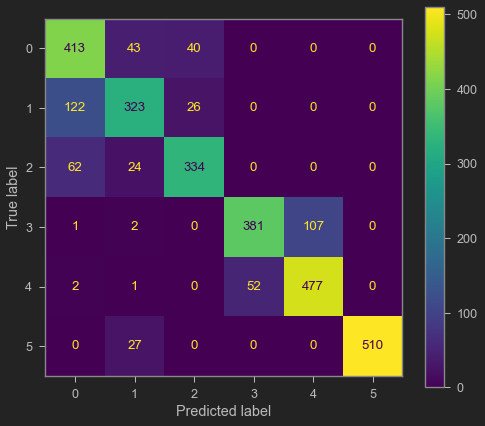

In [30]:
# Mean + STD
display_metrics(y_test_df, prediction)

              precision    recall  f1-score   support

         0.0       0.72      0.75      0.74       496
         1.0       0.77      0.73      0.75       471
         2.0       0.84      0.90      0.87       420
         3.0       0.88      0.78      0.83       491
         4.0       0.82      0.89      0.85       532
         5.0       1.00      0.97      0.98       537

    accuracy                           0.84      2947
   macro avg       0.84      0.84      0.84      2947
weighted avg       0.84      0.84      0.84      2947


ROC-AUC Score: 0.978


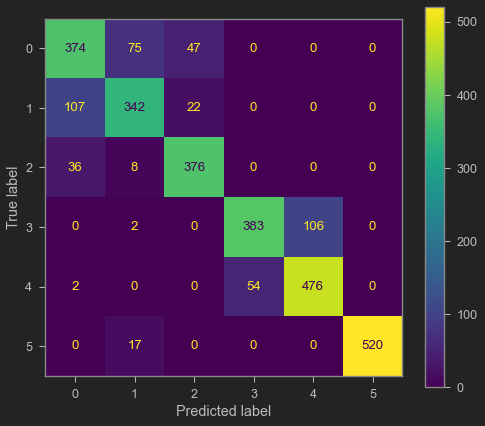

In [18]:
# Mean + STD + Skew + Kurtosis
display_metrics(y_test_df, prediction)

----

#### 3.1. XGB Model

In [24]:
xgb_params = {"booster": "gbtree",
              "objective": "multi:softprob",
              "eval_metric": "auc",
              "learning_rate": 0.1,
              "n_estimators": 1000,
              "num_class": 6,
              "reg_lambda": 50,
              "max_depth": 5,
              "max_leaves": 10,
              "nthread": 5,
              "seed": 32,
             }

In [11]:
# Create 20% of validation data selection
X_train_df_part, X_valid_df_part, y_train_df_part, y_valid_df_part = train_test_split(X_train_df, y_train_df, test_size=0.2, random_state=32)
X_train_df_part.shape, X_valid_df_part.shape, y_train_df_part.shape, y_valid_df_part.shape

((5881, 54), (1471, 54), (5881,), (1471,))

In [26]:
dm_test = xgb.DMatrix(data=X_test_df, label=y_test_df)
dm_train = xgb.DMatrix(data=X_train_df_part, label=y_train_df_part)
dm_valid = xgb.DMatrix(data=X_valid_df_part, label=y_valid_df_part)

In [27]:
xgb_model = xgb.train(params=xgb_params,
                      dtrain=dm_train,
                      num_boost_round=200,
                      early_stopping_rounds=20,
                      evals=[(dm_train, "train"), (dm_valid, "valid")],
                      verbose_eval=20,
                      maximize=True,
                     )

[17:59:57] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.98854	valid-auc:0.98448
[20]	train-auc:0.99778	valid-auc:0.99589
[40]	train-auc:0.99924	valid-auc:0.99770
[60]	train-auc:0.99978	valid-auc:0.99861
[80]	train-auc:0.99993	valid-auc:0.99905
[100]	train-auc:0.99997	valid-auc:0.99927
[120]	train-auc:0.99999	valid-auc:0.99941
[140]	train-auc:1.00000	valid-auc:0.99950
[160]	train-auc:1.00000	valid-auc:0.99957
[180]	train-auc:1.00000	valid-auc:0.99961
[199]	train-auc:1.00000	valid-auc:0.99965


In [28]:
pred = xgb_model.predict(dm_test)
y_test.shape, pred.shape

((2947, 6), (2947, 6))

              precision    recall  f1-score   support

         0.0       0.72      0.77      0.75       496
         1.0       0.76      0.75      0.76       471
         2.0       0.87      0.83      0.85       420
         3.0       0.93      0.85      0.88       491
         4.0       0.87      0.94      0.90       532
         5.0       1.00      1.00      1.00       537

    accuracy                           0.86      2947
   macro avg       0.86      0.86      0.86      2947
weighted avg       0.86      0.86      0.86      2947


ROC-AUC Score: 0.984


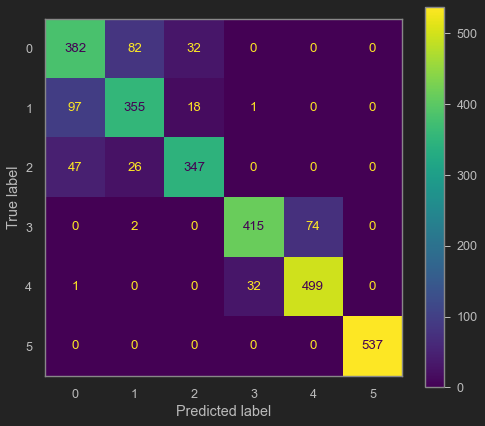

In [31]:
# Display main quality parameters, ROC-AUC score and confusion matrix
display_metrics(y_test_df, pred)

Good result! As it was declared above, we have two different groups of classes (0-2 and 3-5) with more complicated classification inside them (except 5-th class that easily separates from other).  
Lets try to use another boosting-type models.

#### 3.2. LightGBM Model

In [32]:
lgb_params = {"metric": "auc_mu",
              "learning_rate": 0.1,
              "n_estimators": 1000,
              "reg_lambda": 50,
              "max_depth": 5,
              "num_leaves": 10,
              "seed": 32,
             }

In [33]:
lgb_model = lgb.LGBMClassifier(**lgb_params)
lgb_model.fit(X_train_df_part, y_train_df_part, 
              early_stopping_rounds=20, 
              eval_set=[(X_train_df_part, y_train_df_part), (X_valid_df_part, y_valid_df_part)],
              verbose=20)

[20]	training's auc_mu: 0.998203	valid_1's auc_mu: 0.997142
[40]	training's auc_mu: 0.999491	valid_1's auc_mu: 0.998697
[60]	training's auc_mu: 0.999853	valid_1's auc_mu: 0.999207
[80]	training's auc_mu: 0.999945	valid_1's auc_mu: 0.99942
[100]	training's auc_mu: 0.999978	valid_1's auc_mu: 0.99952
[120]	training's auc_mu: 0.999992	valid_1's auc_mu: 0.999601
[140]	training's auc_mu: 0.999996	valid_1's auc_mu: 0.999668
[160]	training's auc_mu: 0.999998	valid_1's auc_mu: 0.999714
[180]	training's auc_mu: 0.999999	valid_1's auc_mu: 0.999744
[200]	training's auc_mu: 1	valid_1's auc_mu: 0.99977
[220]	training's auc_mu: 1	valid_1's auc_mu: 0.999784
[240]	training's auc_mu: 1	valid_1's auc_mu: 0.999799
[260]	training's auc_mu: 1	valid_1's auc_mu: 0.999807
[280]	training's auc_mu: 1	valid_1's auc_mu: 0.999816
[300]	training's auc_mu: 1	valid_1's auc_mu: 0.999819
[320]	training's auc_mu: 1	valid_1's auc_mu: 0.99982
[340]	training's auc_mu: 1	valid_1's auc_mu: 0.999825
[360]	training's auc_mu: 1	

LGBMClassifier(max_depth=5, metric='auc_mu', n_estimators=1000, num_leaves=10,
               reg_lambda=50, seed=32)

In [34]:
pred = lgb_model.predict_proba(X_test_df)
y_test.shape, pred.shape

((2947, 6), (2947, 6))

              precision    recall  f1-score   support

         0.0       0.74      0.78      0.76       496
         1.0       0.78      0.76      0.77       471
         2.0       0.87      0.84      0.85       420
         3.0       0.93      0.84      0.88       491
         4.0       0.87      0.94      0.90       532
         5.0       1.00      1.00      1.00       537

    accuracy                           0.86      2947
   macro avg       0.86      0.86      0.86      2947
weighted avg       0.87      0.86      0.86      2947


ROC-AUC Score: 0.984


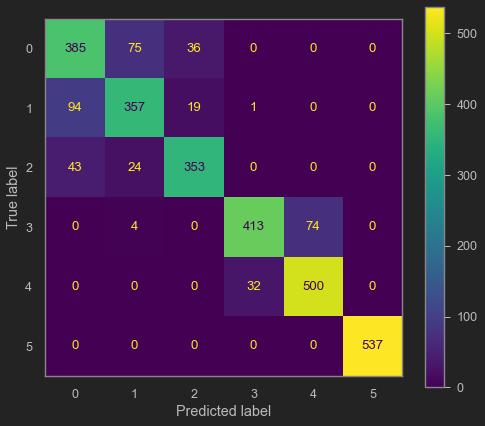

In [35]:
# Display main quality parameters, ROC-AUC score and confusion matrix
display_metrics(y_test_df, pred)

The result is close to XGB but precision and recall metrics a bit better.

#### 3.3. Catboost Model

In [36]:
cb_params = {"objective": "MultiClass",
             "eval_metric": "AUC",
             "learning_rate": 0.1,
             "n_estimators": 1000,
             "reg_lambda": 50,
             "max_depth": 5,
             "thread_count": 5,
             "random_seed": 32,
            }

In [37]:
p_train = cb.Pool(data=X_train_df_part, label=y_train_df_part)
p_valid = cb.Pool(data=X_valid_df_part, label=y_valid_df_part)

In [38]:
cb_model = cb.CatBoostClassifier(**cb_params)
cb_model.fit(p_train, 
             early_stopping_rounds=20,
             eval_set=[p_train, p_valid])

0:	test: 0.9632981	test1: 0.9662986	best: 0.9662986 (0)	total: 95.4ms	remaining: 1m 35s
1:	test: 0.9748859	test1: 0.9771175	best: 0.9771175 (1)	total: 109ms	remaining: 54.3s
2:	test: 0.9765550	test1: 0.9785953	best: 0.9785953 (2)	total: 121ms	remaining: 40s
3:	test: 0.9780899	test1: 0.9799698	best: 0.9799698 (3)	total: 133ms	remaining: 33.1s
4:	test: 0.9797641	test1: 0.9816946	best: 0.9816946 (4)	total: 145ms	remaining: 28.8s
5:	test: 0.9815481	test1: 0.9833940	best: 0.9833940 (5)	total: 156ms	remaining: 25.9s
6:	test: 0.9818737	test1: 0.9829910	best: 0.9833940 (5)	total: 168ms	remaining: 23.9s
7:	test: 0.9833410	test1: 0.9844402	best: 0.9844402 (7)	total: 182ms	remaining: 22.5s
8:	test: 0.9836239	test1: 0.9846146	best: 0.9846146 (8)	total: 197ms	remaining: 21.7s
9:	test: 0.9847508	test1: 0.9861058	best: 0.9861058 (9)	total: 211ms	remaining: 20.9s
10:	test: 0.9857976	test1: 0.9869650	best: 0.9869650 (10)	total: 226ms	remaining: 20.4s
11:	test: 0.9865693	test1: 0.9876645	best: 0.9876645

In [39]:
pred = cb_model.predict_proba(X_test_df)
y_test.shape, pred.shape

((2947, 6), (2947, 6))

              precision    recall  f1-score   support

         0.0       0.71      0.77      0.74       496
         1.0       0.77      0.75      0.76       471
         2.0       0.87      0.80      0.84       420
         3.0       0.91      0.79      0.85       491
         4.0       0.83      0.93      0.88       532
         5.0       1.00      1.00      1.00       537

    accuracy                           0.85      2947
   macro avg       0.85      0.84      0.84      2947
weighted avg       0.85      0.85      0.85      2947


ROC-AUC Score: 0.982


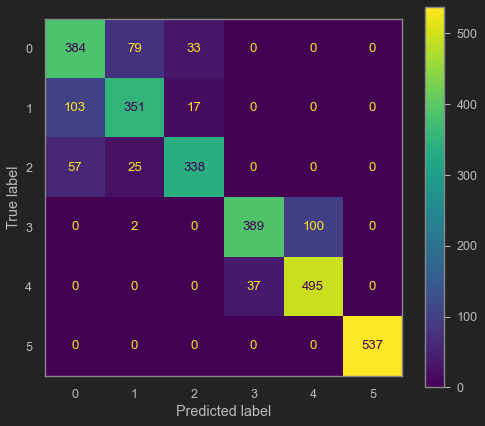

In [40]:
# Display main quality parameters, ROC-AUC score and confusion matrix
display_metrics(y_test_df, pred)

Catboost model has the less metrics...

### 4. Feature importance analysis

Not all features are equally usefull! Let's make model more effective, filter useless features.  
There are few methods to check feature importance. I preffer permutation importance and shaply and I used the first one in the task.

In [45]:
importance = permutation_importance(lgb_model, X_valid_df_part, y_valid_df_part, scoring="roc_auc_ovo", n_jobs=-1, random_state=32)

In [46]:
importance_scores = pd.DataFrame({"features": X_valid_df_part.columns,
                                  "importance-mean": importance.importances_mean,
                                  "importance-std": importance.importances_std})
importance_scores = importance_scores.sort_values(by="importance-mean", ascending=False)
importance_scores = importance_scores.reset_index(drop=True)
importance_scores

,features,importance-mean,importance-std
0,X0_mean,4.139464e-02,1.123226e-03
1,X1_mean,8.125413e-03,8.232170e-04
2,X3_std,1.067702e-03,2.240813e-04
3,X6_max,6.035746e-04,1.185621e-04
4,X6_std,3.886345e-04,1.464545e-04
5,X2_mean,3.187120e-04,2.595711e-05
6,X0_min,2.508922e-04,9.753255e-05
7,X6_min,2.186520e-04,6.963972e-05
8,X1_max,2.108922e-04,4.821782e-05
9,X3_max,1.357835e-04,7.841684e-05


In [47]:
# Delete useless features and retrain the model
feature_selection = importance_scores.loc[importance_scores['importance-mean'] > 0, 'features'].values

lgb_model_fs = lgb.LGBMClassifier(**lgb_params)
lgb_model_fs.fit(X_train_df_part[feature_selection], y_train_df_part, 
                 early_stopping_rounds=20, 
                 eval_set=[(X_train_df_part[feature_selection], y_train_df_part), (X_valid_df_part[feature_selection], y_valid_df_part)],
                 verbose=20)

[20]	valid_0's auc_mu: 0.998138	valid_1's auc_mu: 0.996951
[40]	valid_0's auc_mu: 0.999476	valid_1's auc_mu: 0.998704
[60]	valid_0's auc_mu: 0.999847	valid_1's auc_mu: 0.999244
[80]	valid_0's auc_mu: 0.999941	valid_1's auc_mu: 0.999434
[100]	valid_0's auc_mu: 0.999977	valid_1's auc_mu: 0.999556
[120]	valid_0's auc_mu: 0.999991	valid_1's auc_mu: 0.999636
[140]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999686
[160]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999723
[180]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999756
[200]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999781
[220]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999796


LGBMClassifier(max_depth=5, metric='auc_mu', n_estimators=1000, num_leaves=10,
               reg_lambda=50, seed=32)

              precision    recall  f1-score   support

         0.0       0.73      0.76      0.75       496
         1.0       0.77      0.76      0.76       471
         2.0       0.86      0.84      0.85       420
         3.0       0.92      0.85      0.88       491
         4.0       0.87      0.93      0.90       532
         5.0       1.00      1.00      1.00       537

    accuracy                           0.86      2947
   macro avg       0.86      0.86      0.86      2947
weighted avg       0.86      0.86      0.86      2947


ROC-AUC Score: 0.984


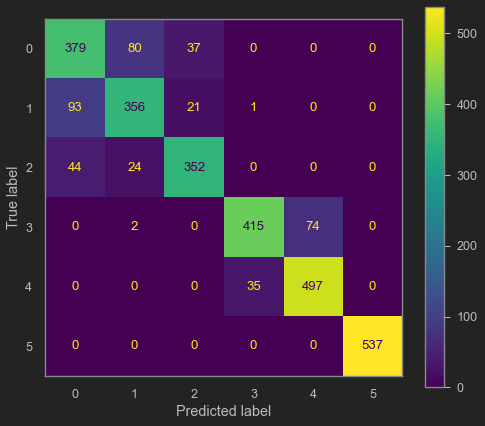

In [48]:
pred = lgb_model_fs.predict_proba(X_test_df[feature_selection])
display_metrics(y_test_df, pred)

### 5. Tunning of hyperparameters

In [97]:
def objective(trial):

    params = {"n_estimators": 1000,
              "metric": "auc_mu",
              "early_stopping_rounds": 20,
              "verbose": 0,
              "random_seed": 32,
              # Tunning
              "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 60),
              "max_depth": trial.suggest_int("max_depth", 2, 8),
              "num_leaves": trial.suggest_int("num_leaves", 10, 30),
              "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
             }

    lgb_model = lgb.LGBMClassifier(**params)
    lgb_model.fit(X_train_df_part[feature_selection], y_train_df_part, eval_set=[(X_train_df_part[feature_selection], y_train_df_part), (X_valid_df_part[feature_selection], y_valid_df_part)])

    return roc_auc_score(y_test_df.values, lgb_model.predict_proba(X_test_df[feature_selection]), multi_class="ovo")

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

In [99]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial_full = study.best_trial
print("  Value: {}".format(trial_full.value))
print("  Params: ")
for key, value in trial_full.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 50
Best trial:
  Value: 0.9846428557026247
  Params: 
    reg_lambda: 32.044015659373045
    max_depth: 2
    num_leaves: 20
    learning_rate: 0.08663110372919475


In [100]:
# Include optimal parameters in the model
lgb_params.update(trial_full.params)

lgb_model_fs = lgb.LGBMClassifier(**lgb_params)
lgb_model_fs.fit(X_train_df_part[feature_selection], y_train_df_part, 
                 early_stopping_rounds=20, 
                 eval_set=[(X_train_df_part[feature_selection], y_train_df_part), (X_valid_df_part[feature_selection], y_valid_df_part)],
                 verbose=20)

[20]	valid_0's auc_mu: 0.993754	valid_1's auc_mu: 0.993224
[40]	valid_0's auc_mu: 0.996778	valid_1's auc_mu: 0.996152
[60]	valid_0's auc_mu: 0.998254	valid_1's auc_mu: 0.997551
[80]	valid_0's auc_mu: 0.998974	valid_1's auc_mu: 0.998223
[100]	valid_0's auc_mu: 0.999357	valid_1's auc_mu: 0.998629
[120]	valid_0's auc_mu: 0.999559	valid_1's auc_mu: 0.998844
[140]	valid_0's auc_mu: 0.999689	valid_1's auc_mu: 0.999014
[160]	valid_0's auc_mu: 0.999792	valid_1's auc_mu: 0.99916
[180]	valid_0's auc_mu: 0.999858	valid_1's auc_mu: 0.999261
[200]	valid_0's auc_mu: 0.999904	valid_1's auc_mu: 0.99934
[220]	valid_0's auc_mu: 0.999934	valid_1's auc_mu: 0.999398
[240]	valid_0's auc_mu: 0.999952	valid_1's auc_mu: 0.999445
[260]	valid_0's auc_mu: 0.999965	valid_1's auc_mu: 0.999482
[280]	valid_0's auc_mu: 0.999976	valid_1's auc_mu: 0.99952
[300]	valid_0's auc_mu: 0.999984	valid_1's auc_mu: 0.999561
[320]	valid_0's auc_mu: 0.999989	valid_1's auc_mu: 0.999595
[340]	valid_0's auc_mu: 0.999992	valid_1's auc_

LGBMClassifier(learning_rate=0.08663110372919475, max_depth=2, metric='auc_mu',
               n_estimators=1000, num_leaves=20, reg_lambda=32.044015659373045,
               seed=32)

              precision    recall  f1-score   support

         0.0       0.76      0.79      0.77       496
         1.0       0.76      0.78      0.77       471
         2.0       0.87      0.81      0.84       420
         3.0       0.92      0.85      0.88       491
         4.0       0.88      0.94      0.91       532
         5.0       1.00      1.00      1.00       537

    accuracy                           0.87      2947
   macro avg       0.86      0.86      0.86      2947
weighted avg       0.87      0.87      0.87      2947


ROC-AUC Score: 0.985


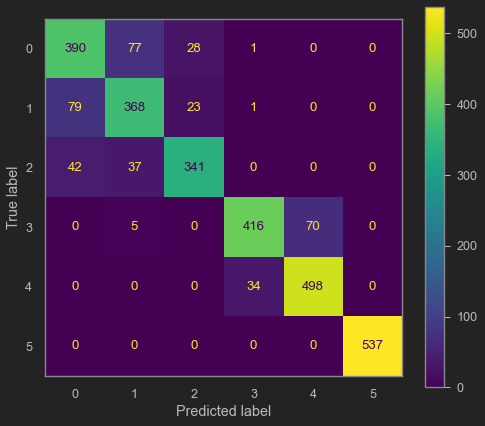

In [101]:
pred = lgb_model_fs.predict_proba(X_test_df[feature_selection])
display_metrics(y_test_df, pred)

### 6. Neural Networks

Let's make some tests with neural networks to solve the task.

#### 6.1 Simple dense model

In [118]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [106]:
flatten_size = X_train.shape[1] * X_train.shape[2]
classes = y_train.shape[1]
train_nn = X_train.reshape((-1, flatten_size))
test_nn = X_test.reshape((-1, flatten_size))

In [107]:
train_nn.shape, test_nn.shape

((7352, 1152), (2947, 1152))

In [120]:
model = Sequential()
model.add(Dense(128, activation='tanh', input_shape=(flatten_size,)))
model.add(Dropout(0.5, input_shape=(flatten_size,)))
model.add(Dense(128, activation='tanh', input_shape=(flatten_size,)))
model.add(Dropout(0.5, input_shape=(flatten_size,)))
model.add(Dense(classes, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['AUC']) 

history = model.fit(train_nn,
                    y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)
                
model.evaluate(test_nn, y_test)

Epoch 1/100
184/184 [==============================] - 1s 3ms/step - loss: 1.1962 - auc: 0.8549 - val_loss: 1.2099 - val_auc: 0.9021
Epoch 2/100
184/184 [==============================] - 0s 2ms/step - loss: 0.9329 - auc: 0.9107 - val_loss: 1.0974 - val_auc: 0.9263
Epoch 3/100
184/184 [==============================] - 0s 2ms/step - loss: 0.7467 - auc: 0.9433 - val_loss: 0.9010 - val_auc: 0.9467
Epoch 4/100
184/184 [==============================] - 0s 2ms/step - loss: 0.6180 - auc: 0.9611 - val_loss: 0.8953 - val_auc: 0.9496
Epoch 5/100
184/184 [==============================] - 0s 2ms/step - loss: 0.5137 - auc: 0.9726 - val_loss: 0.8444 - val_auc: 0.9575
Epoch 6/100
184/184 [==============================] - 0s 2ms/step - loss: 0.4533 - auc: 0.9784 - val_loss: 0.8379 - val_auc: 0.9608
Epoch 7/100
184/184 [==============================] - 0s 2ms/step - loss: 0.4128 - auc: 0.9815 - val_loss: 0.8470 - val_auc: 0.9624
Epoch 8/100
184/184 [==============================] - 0s 2ms/step - 

[0.7816063165664673, 0.9751165509223938]

The result reached by dense neural networks (ROC-AUC 0.975) is less than by boosting models...

#### 6.2 Convolutional neural networks

As input data has 'N*(128,9)' dimention convolutional NN model can be usefull for this type of data.

In [127]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Concatenate, Conv1D, MaxPooling1D, Input, Conv2D, MaxPooling2D

##### 1D CNN 

In [130]:
input_layer = Input(shape=(X_train.shape[1:]))

conv_1 = Conv1D(32, 3, padding='same', activation='relu')(input_layer)
conv_2 = Conv1D(32, 3, padding='same', activation='relu')(conv_1)
pooling_1 = MaxPooling1D(pool_size=2)(conv_2)
dropout_1 = Dropout(0.25)(pooling_1)

conv_3 = Conv1D(64, 3, padding='same', activation='relu')(dropout_1)
conv_4 = Conv1D(64, 3, padding='same', activation='relu')(conv_3)
pooling_2 = MaxPooling1D(pool_size=2)(conv_4)
dropout_2 = Dropout(0.25)(pooling_2)

flatten_layer = Flatten()(dropout_2)
dense_layer = Dense(512, activation='relu')(flatten_layer)
dropout_3 = Dropout(0.5)(dense_layer)

output_layer = Dense(classes, activation='softmax')(dropout_3)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['AUC'])

model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1, validation_split=0.2)
model.evaluate(X_train, y_train, verbose=1)
model.evaluate(X_test, y_test, verbose=1)

Epoch 1/100
184/184 [==============================] - 4s 18ms/step - loss: 0.5791 - auc: 0.9652 - val_loss: 0.3452 - val_auc: 0.9885
Epoch 2/100
184/184 [==============================] - 3s 17ms/step - loss: 0.1653 - auc: 0.9964 - val_loss: 0.3633 - val_auc: 0.9793
Epoch 3/100
184/184 [==============================] - 4s 24ms/step - loss: 0.1347 - auc: 0.9974 - val_loss: 0.2909 - val_auc: 0.9890
Epoch 4/100
184/184 [==============================] - 3s 16ms/step - loss: 0.0974 - auc: 0.9988 - val_loss: 0.3374 - val_auc: 0.9806
Epoch 5/100
184/184 [==============================] - 3s 16ms/step - loss: 0.0963 - auc: 0.9988 - val_loss: 0.4160 - val_auc: 0.9787
Epoch 6/100
184/184 [==============================] - 3s 17ms/step - loss: 0.0939 - auc: 0.9989 - val_loss: 0.5676 - val_auc: 0.9670
Epoch 7/100
184/184 [==============================] - 3s 16ms/step - loss: 0.0915 - auc: 0.9988 - val_loss: 0.5205 - val_auc: 0.9776
Epoch 8/100
184/184 [==============================] - 3s 18ms

[1.887313723564148, 0.9717043042182922]

The result (ROC-AUC 0.972) is lower then boosting models as well as from simple dense NN.  

##### 2D CNN (for an experiment)

In [12]:
X_train_4Dtensor = X_train.reshape(-1, 128, 9, 1)
X_test_4Dtensor = X_test.reshape(-1, 128, 9, 1)
classes = y_train.shape[1]

In [13]:
input_layer = Input(shape=(X_train_4Dtensor.shape[1:]))

conv_1 = Conv2D(32, (3, 3), padding='same', activation='relu')(input_layer)
conv_2 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv_1)
pooling_1 = MaxPooling2D(pool_size=(2, 2))(conv_2)
dropout_1 = Dropout(0.25)(pooling_1)

conv_3 = Conv2D(64, (3, 3), padding='same', activation='relu')(dropout_1)
conv_4 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv_3)
pooling_2 = MaxPooling2D(pool_size=(2, 2))(conv_4)
dropout_2 = Dropout(0.25)(pooling_2)

flatten_layer = Flatten()(dropout_2)
dense_layer = Dense(512, activation='relu')(flatten_layer)
dropout_3 = Dropout(0.5)(dense_layer)

output_layer = Dense(classes, activation='softmax')(dropout_3)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['AUC'])

model.fit(X_train_4Dtensor, y_train, batch_size=32, epochs=100, verbose=1, validation_split=0.2)
model.evaluate(X_train_4Dtensor, y_train, verbose=1)
model.evaluate(X_test_4Dtensor, y_test, verbose=1)

Epoch 1/100
184/184 [==============================] - 14s 74ms/step - loss: 0.5112 - auc: 0.9722 - val_loss: 0.5111 - val_auc: 0.9657
Epoch 2/100
184/184 [==============================] - 13s 73ms/step - loss: 0.1460 - auc: 0.9972 - val_loss: 0.4729 - val_auc: 0.9718
Epoch 3/100
184/184 [==============================] - 13s 73ms/step - loss: 0.1168 - auc: 0.9981 - val_loss: 0.4130 - val_auc: 0.9815
Epoch 4/100
184/184 [==============================] - 13s 72ms/step - loss: 0.0829 - auc: 0.9991 - val_loss: 0.5906 - val_auc: 0.9669
Epoch 5/100
184/184 [==============================] - 13s 73ms/step - loss: 0.0705 - auc: 0.9992 - val_loss: 0.7126 - val_auc: 0.9674
Epoch 6/100
184/184 [==============================] - 13s 73ms/step - loss: 0.0672 - auc: 0.9992 - val_loss: 0.6384 - val_auc: 0.9680
Epoch 7/100
184/184 [==============================] - 13s 73ms/step - loss: 0.0839 - auc: 0.9987 - val_loss: 1.0573 - val_auc: 0.9664
Epoch 8/100
184/184 [==============================] - 

[12.869426727294922, 0.9579042196273804]

ROC-AUC 0.958 is too low...  
There could be more experiments with NN but final metric quite far from boosting model and I don't think that NN tunning get much better result than boosting models.

### SUMMARY:
Modelling showed the next ROC-AUC results:
1. XGBoost - 0.984
2. LightGBM - 0.984 (0.985 after final tunning)
3. Catboost - 0.982
4. Dense NN model - 0.975
5. CNN model - 0.972 (1D) / 0.958 (2D)

##### The best model LightGBM showed 0.985 ROC-AUC result on test_data, hence the model is recommended to use for operating mode choose.